In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import ipywidgets as widgets
from ipywidgets import RadioButtons
from IPython.display import display, clear_output
from scipy.signal import upfirdn, convolve
from ipywidgets import Checkbox, Button, Output, VBox, HBox, Dropdown



In [2]:
def generate_histogram(k):
    M = 40000
    L = 2 ** k

    x = 2 * np.floor(L * np.random.rand(M)) - L + 1
    bins = np.arange(-L, L + 2, 2)
    A = np.arange(-(L - 1), L, 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.hist(x, bins=bins, edgecolor='white', color='#1F77B4')  # Use ax.hist for compatibility with widgets
    ax.set_xticks(A)
    ax.set_xlabel("Integers")
    ax.set_ylabel("Frequency")
    ax.set_title("Histogram of array x elements")
    plt.show()

k_input = widgets.IntText(
    value=3,  # default value
    description='k:',
    continuous_update=False
)

ui = widgets.VBox([k_input])
out = widgets.interactive_output(generate_histogram, {'k': k_input})

# Display the UI components
display(ui, out)

Output()

In [3]:
def generate_histogram(k, EbN0_db):
    M = 60000
    nsamp = 16

    L = 2**k
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    P_x = (L**2 - 1) / 3
    Measured_x = np.sum(x**2)/len(x)

    y = np.repeat(x, nsamp)

    noise = np.random.normal(0, np.sqrt(Measured_x/SNR), len(y))
    y_noisy = y + noise

    y_reshaped = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp, 1))
    z = np.matmul(y_reshaped, matched) / nsamp

    A = np.arange(-(L-1), L, 2)  # Adjusted to use inside plotting
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.hist(z, bins=200,  edgecolor='white', color='#1F77B4')
    ax.set_xticks(A)
    ax.set_xlabel("Integers")
    ax.set_ylabel("Frequency")
    ax.legend(["Eb/N0 = " + str(EbN0_db)])
    ax.set_title('Histogram of the Noisy Signal')
    plt.show()

k_input = widgets.IntText(
    value=3,  # default value
    description='k:',
    continuous_update=False
)

EbN0_db_slider = widgets.FloatSlider(
    value=12,  # default value
    min=0,    # minimum value
    max=20,   # maximum value
    step=0.1,   # step size
    description='Eb/N0 (dB):',
    continuous_update=False
)

ui = widgets.VBox([k_input, EbN0_db_slider])

out = widgets.interactive_output(generate_histogram, {'k': k_input, 'EbN0_db': EbN0_db_slider})

# Display the UI components
display(ui, out)

Output()

In [4]:
def ask_errors(k,M,nsamp,EbN0_db):
    
    L = 2**k
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    SNR = 10 ** (SNR_db * 0.1)
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    P_x = (L*L-1) / 3
    Measured_x = np.sum(x*x)/len(x)

    y = []
    for i in range(len(x)):
        for j in range(nsamp):
            y.append(x[i])
    y = np.array(y)

    noise = np.random.normal(0, np.sqrt(Measured_x/SNR),len(y))
    y_noisy = y + noise

    y = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp,1))
    z = np.matmul(y, matched)
    z = z / nsamp
    l = np.arange(-L+1,L,2)

    z = z[:,0]
    for i in range(len(z)):
        differences = np.abs(l-z[i]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        z[i] = l[index]
    
    errors = 0
    for i in range(len(z)):
        if x[i] != z[i]:
            errors += 1
    
    return errors


M = 20000
nsamp = 16
EbN0_db = np.arange(0, 10, 1)
EbN0 = 10**(EbN0_db / 10)

# Create checkboxes for each modulation level
checkbox_4qam = Checkbox(value=True, description='4-ASK')
checkbox_8qam = Checkbox(value=False, description='8-ASK')
checkbox_16qam = Checkbox(value=False, description='16-ASK')

plot_output = Output()

def plot_selected_modulations(btn=None):
    with plot_output:
        clear_output(wait=True)
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-ASK': ('red', 'tomato'),
            '8-ASK': ('green', 'limegreen'),
            '16-ASK': ('blue', 'dodgerblue')
        }
        
        for i, (k, checkbox) in enumerate(zip([2, 3, 4], [checkbox_4qam, checkbox_8qam, checkbox_16qam])):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-ASK'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER using a placeholder function
                    ber[index] = ask_errors(k, M, nsamp, index) / M / np.log2(L)
                
                # Plot experimental BER as points without connecting lines, using specific colors
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=colors[modulation_name][0])
                
                # Theoretical BER for comparison, with distinct line color
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(EbN0 * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=colors[modulation_name][1])

        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.legend()
        plt.title('Theoretical and Experimental BER of ask_errors')
        plt.show()

# Button to update the plot
plot_button = Button(description="Plot")
plot_button.on_click(plot_selected_modulations)

# Initially plot with default settings
plot_selected_modulations()

# Displaying the widgets and the output container
display(VBox([checkbox_4qam, checkbox_8qam, checkbox_16qam, plot_button]), plot_output)

Output()

In [5]:
def ask_errors_new(k, M, nsamp, EbN0_db):
    # Constants and signal generation
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Filter impulse response: orthogonal pulse of unit energy
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Upsample x
    y_upsampled = np.zeros(M * nsamp)
    y_upsampled[::nsamp] = x

    # Convolution with the filter impulse response
    y = np.convolve(y_upsampled, h, mode='full')[:M*nsamp]

    # Filter impulse response: orthogonal pulse of unit energy

    # Add AWGN
    signal_power = np.mean(y**2)
    SNR_linear = 10**(SNR_db / 10)
    noise_power = signal_power / SNR_linear
    # Correctly define y_noisy
    noise = np.random.normal(0, np.sqrt(noise_power), y.shape)
    y_noisy = y + noise  # This should correctly define y_noisy

    # Matched filter
    matched = h[::-1]
    yrx = np.convolve(y_noisy, matched, mode='full')  # Make sure to use y_noisy here

    # Sampling at the end of each symbol period
    z = yrx[nsamp-1::nsamp][:M]  # Ensure we only get M samples



    # Decision making
    l = np.arange(-L + 1, L, 2)
    z_decoded = np.zeros(M, dtype=int)
    for i in range(M):
        index = np.argmin(np.abs(l - z[i]))
        z_decoded[i] = l[index]

    # Count errors
    errors = np.sum(x != z_decoded)

    return errors



M = 20000
EbN0_db = np.arange(0, 10, 1)

# Initialize the widgets
checkbox_4qam1 = Checkbox(value=True, description='4-ASK')
checkbox_8qam1 = Checkbox(value=False, description='8-ASK')
checkbox_16qam1 = Checkbox(value=False, description='16-ASK')
nsamp_dropdown1 = Dropdown(options=[4, 8, 16, 32, 64], value=16, description='Samples per Symbol:', style={'description_width': 'initial'})

plot_output1 = Output()

def plot_selected_modulations1(btn=None):
    with plot_output1:
        clear_output(wait=True)
        nsamp = nsamp_dropdown1.value  # Get the selected value from the dropdown
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-ASK': 'red',
            '8-ASK': 'green',
            '16-ASK': 'blue'
        }
        
        for k, checkbox, color in zip([2, 3, 4], [checkbox_4qam1, checkbox_8qam1, checkbox_16qam1], colors.values()):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-ASK'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER
                    ber[index] = ask_errors_new(k, M, nsamp, eb_n0) / (M * np.log2(L))
                
                # Plot experimental BER
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)
                
                # Theoretical BER for comparison
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(10**(EbN0_db / 10) * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)
        
        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.title('Theoretical and Experimental BER of modified ask_errors')
        plt.legend()
        plt.show()

# Button to update the plot based on the selected nsamp
plot_button1 = Button(description="Plot")
plot_button1.on_click(plot_selected_modulations1)

# Display the widgets and the output container
display(HBox([nsamp_dropdown1]), VBox([checkbox_4qam1, checkbox_8qam1, checkbox_16qam1, plot_button1]), plot_output1)

# Call the function initially to display the plot
plot_selected_modulations1()

Output()

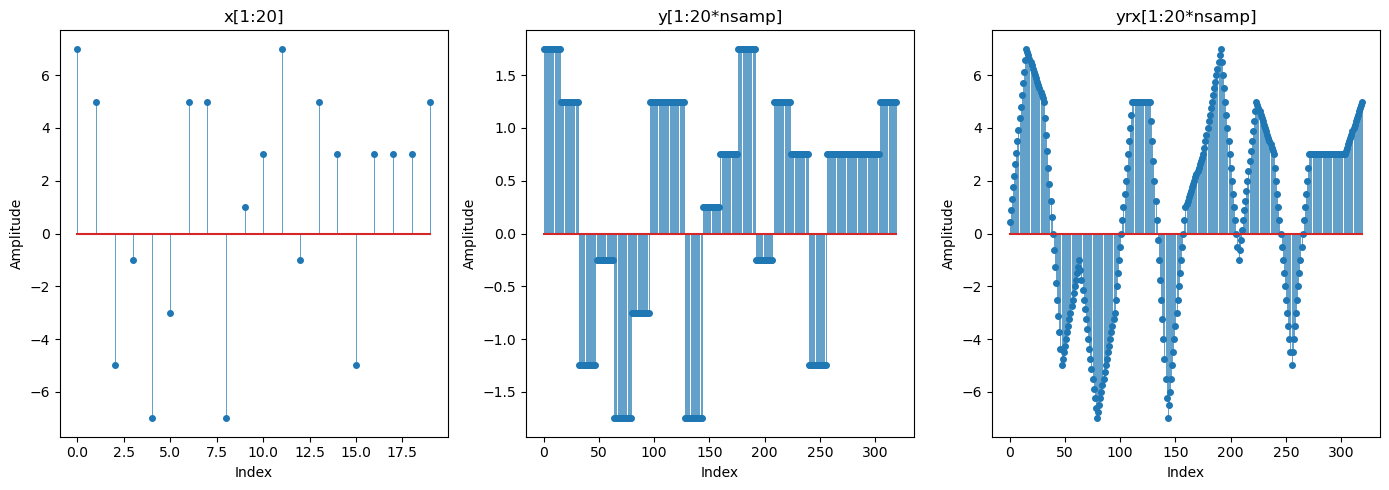

In [6]:
def ask_errors_modified(k, M, nsamp, add_noise=False):
    L = 2**k
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the filter impulse response
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]  # Cutting the last elements of convolution if any

    # Optionally add noise
    y_noisy = y
    if add_noise:
        SNR_db = 10  # Example SNR value, adjust as necessary
        SNR_linear = 10 ** (SNR_db / 10)
        P_x = np.mean(y ** 2)  # Signal power
        noise_variance = P_x / SNR_linear
        noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
        y_noisy = y + noise

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is a time-reversed version of h
    yrx = convolve(y_noisy, matched, mode='full')
    yrx = yrx[:M * nsamp]  # Adjust length to match y

    # Returning slices for visualization
    return x[:20], y[:20*nsamp], yrx[:20*nsamp]


import matplotlib.pyplot as plt

k=3
# Get the signal parts
x_part, y_part, yrx_part = ask_errors_modified(k, M, nsamp, add_noise=False)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Plot x
markerline, stemlines, baseline = axs[0].stem(x_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[0].set_title('x[1:20]')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Amplitude')

# Plot y
markerline, stemlines, baseline = axs[1].stem(y_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[1].set_title('y[1:20*nsamp]')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Amplitude')

# Plot yrx
markerline, stemlines, baseline = axs[2].stem(yrx_part)
plt.setp(stemlines, 'linewidth', 0.5)  # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)  # Set the marker size
axs[2].set_title('yrx[1:20*nsamp]')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, upfirdn
from scipy.special import erfc
from ipywidgets import Checkbox, Dropdown, Button, Output, VBox, HBox, RadioButtons
from IPython.display import display, clear_output

def ask_errors_sin_wrong(k, M, nsamp, EbN0_db, matched_filter_type='Normal'):
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR_linear = 10 ** (SNR_db / 10)
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    h = np.cos(2 * np.pi * np.arange(1, nsamp + 1) / nsamp)
    h = h / np.sqrt(np.sum(h**2))

    y = upfirdn(h, x, up=nsamp)
    y = y[:M * nsamp]

    P_x = np.mean(y ** 2)
    noise_variance = P_x / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
    y_noisy = y + noise

    matched = h[::-1] if matched_filter_type == 'Reversed' else h
    yrx = np.convolve(y_noisy, matched, mode='full')
    z = yrx[nsamp - 1:M * nsamp:nsamp]

    levels = np.arange(-L + 1, L, 2)
    z_decided = levels[np.abs(levels[:, None] - z).argmin(axis=0)]

    errors = np.count_nonzero(x != z_decided)

    return errors

matched_radio = RadioButtons(
    options=['Normal', 'Reversed'],
    value='Normal',
    description='Matched Filter:',
    disabled=False
)

M = 20000
EbN0_db = np.arange(0, 10, 1)

checkbox_4qam4 = Checkbox(value=True, description='4-ASK')
checkbox_8qam4 = Checkbox(value=False, description='8-ASK')
checkbox_16qam4 = Checkbox(value=False, description='16-ASK')
nsamp_dropdown4 = Dropdown(options=[4, 8, 16, 32, 64], value=16, description='Samples per Symbol:', style={'description_width': 'initial'})

plot_output4 = Output()

def plot_selected_modulations4(btn=None):
    with plot_output4:
        clear_output(wait=True)
        nsamp = nsamp_dropdown4.value
        matched_filter_type = matched_radio.value
        plt.figure(figsize=(10, 7))
        colors = {'4-ASK': 'red', '8-ASK': 'green', '16-ASK': 'blue'}

        for k, checkbox, color in zip([2, 3, 4], [checkbox_4qam4, checkbox_8qam4, checkbox_16qam4], colors.values()):
            if checkbox.value:
                L = 2**k
                modulation_name = f'{L}-ASK'
                ber = np.zeros(len(EbN0_db))
                for index, eb_n0 in enumerate(EbN0_db):
                    ber[index] = ask_errors_sin_wrong(k, M, nsamp, eb_n0, matched_filter_type) / (M * np.log2(L))

                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)
                ber_theoretical = (((L-1)/L) * erfc(np.sqrt(10**(EbN0_db / 10) * (3 * np.log2(L)) / (L**2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)

        plt.grid(True, which='both')
        plt.xlabel("Eb/N0 (dB)")
        plt.ylabel("BER")
        plt.title('Theoretical and Experimental BER of ASK Modulations')
        plt.legend()
        plt.show()

matched_radio.observe(plot_selected_modulations4, names='value')
plot_button4 = Button(description="Plot")
plot_button4.on_click(plot_selected_modulations4)
display(HBox([nsamp_dropdown4, matched_radio]), VBox([checkbox_4qam4, checkbox_8qam4, checkbox_16qam4, plot_button4]), plot_output4)
plot_selected_modulations4()


Output()

In [8]:
# Adjusted function to plot filters
def plot_filters(nsamp):
    orthogonal = np.ones(nsamp) / np.sqrt(nsamp)
    sinusoidal = np.cos(2 * np.pi * np.arange(1, nsamp + 1) / nsamp)
    sinusoidal = sinusoidal / np.sqrt(np.sum(sinusoidal**2))

    matched_orthogonal = orthogonal[::-1]
    matched_sinusoidal = sinusoidal[::-1]

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    markerline, stemlines, baseline = axs[0,0].stem(orthogonal)
    plt.setp(stemlines, 'linewidth', 0.5)
    plt.setp(markerline, 'markersize', 4)
    axs[0,0].set_title('Orthogonal')
    axs[0,0].set_xlabel('Index')
    axs[0,0].set_ylabel('Amplitude')

    markerline, stemlines, baseline = axs[0,1].stem(sinusoidal)
    plt.setp(stemlines, 'linewidth', 0.5)
    plt.setp(markerline, 'markersize', 4)
    axs[0,1].set_title('Sinusoidal')
    axs[0,1].set_xlabel('Index')
    axs[0,1].set_ylabel('Amplitude')

    markerline, stemlines, baseline = axs[1,0].stem(matched_orthogonal)
    plt.setp(stemlines, 'linewidth', 0.5)
    plt.setp(markerline, 'markersize', 4)
    axs[1,0].set_title('Matched Orthogonal')
    axs[1,0].set_xlabel('Index')
    axs[1,0].set_ylabel('Amplitude')

    markerline, stemlines, baseline = axs[1,1].stem(matched_sinusoidal)
    plt.setp(stemlines, 'linewidth', 0.5)
    plt.setp(markerline, 'markersize', 4)
    axs[1,1].set_title('Matched Sinusoidal')
    axs[1,1].set_xlabel('Index')
    axs[1,1].set_ylabel('Amplitude')

    plt.tight_layout()
    return fig

# Widget UI components with Dropdown
nsamp_input = widgets.Dropdown(
    options=[8, 16, 32, 64],
    value=8,  # Default value
    description='nsamp:',
)

plot_button = widgets.Button(description="Update Plot")
output = widgets.Output()

# Button click event handler
def on_plot_button_clicked(b):
    with output:
        clear_output(wait=True)
        plot_filters(nsamp_input.value)
        plt.show()

plot_button.on_click(on_plot_button_clicked)

# Display UI
ui = widgets.VBox([nsamp_input, plot_button, output])
display(ui)

# Show initial plot automatically
with output:
    plot_filters(nsamp_input.value)
    plt.show()
